# Sparkify Project 

## Table of Contents
1. [Overview](#overview)
2. [Import required packages](#packages)
3. [Workflow](#workflow)
    1. [Load and Clean Dataset](#preprocess)
    2. [Exploratory Data Analysis](#eda)
        1. [Convert time](#time_convert)
        2. [Define churn](#churn)
        3. [Explore Data](#data)
4. [Feature Engineer](#feature_engineer)
5. [Modelling](#modelling)
    1. [Baseline](#baseline)
    2. [Logistic Regression](#logistic)
    3. [Gradient Boosted Trees](#gbt)
    4. [Support Vector Machine](#svm)
    5. [Random Forest](#rf)
    6. [Best model](#best_model)
6. [Conclusion](#conclusion)

# Overview <a id='overview'></a>

Sparkify is a music streaming service like Pandora and Spotify.

The dataset provided includes the user log of the service, user's demographic info, user activities, timestamps and etc. 

In this project, we try to analyze the log of the users and build a ML model capable of identifing the customers who are highly likely to cancel their account and stop using our service. The outcome of the model will help us send those users marketing offers in order to prevent them from churning. 

The main problem of this project is to predict customer churn in advance and I will try to solve it by  using Spark (PySpark) and the Random Forest model.

F1 score will be our ecaluation metric of the model performance as it's crucial nopt to miss a great ammount of users who are likely to quit the srvices while we don't want to waste resources on users who are not likely to cancell their subscription in the music service. In simple words, we need both precision and recall to evaluate our model.
We performed EDA to investigate features and explore data, and train multiple machine learning models before we end up with the optimal one.

**Our final and optimal model reported a F1 score of 76%, which is 16% higher than sending offers to all the users. An article in Medium about this project is also posted here.**


# Import required packages <a id='packages'></a>

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from time import time

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.sql import SparkSession

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler, HashingTF, Tokenizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [3]:
# Create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Churn Prediction") \
    .getOrCreate()

# Workflow <a id='workflow'></a>

The workflow of this projest consist of steps that we will follow are: 

    1. Load and clean Dataset 
        1.1. Load the data from the json file into a Spark dataframe.
        1.2. Delete the missing values (NAs) and remove rows where the UserId is missing. 
    2. Exploratory Data Analysis
        2.1. Convert the 'registration' and 'ts' columns into human readable format, specifically Y-m-d H:M:S.
        2.2. Engineer a new feature, the churn column. 
        2.3. Explore Data 


## 1. Load and clean Dataset <a id='preprocess'></a>

### 1.1 First, we load the date and we take a look at the Spark dataframe

In [4]:
def load_json_data(json_filepath):
    """
    Load JSON data from a given path into Spark frame.
    
    Parameters:
    json_filepath (str): The path to the JSON file. 
    
    
    Returns:
    df (PySpark DataFrame): The Spark dataframe created by the json data. 
    """
    
    df = spark.read.json(json_filepath)
    return df

In [5]:
json_filepath = "mini_sparkify_event_data.json"
user_logs = load_json_data(json_filepath)

We will be investigate several aspects of the dataset, including schema, dimension, and missing values. A glimpse of the dataset that we will deal with:

In [6]:
user_logs.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
user_logs.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
def data_shape(df):
    """
    Print the shape of a PySpark DataFrame
    
    Parameters:
    df (DataFrame): The PySpark DataFrame.
    
    Returns,
    shape (list): The non-NA elements for each column and the number of columns. 
    
    """
    shape = [df.count(), len(df.columns)]
    return(shape)



In [9]:
data_shape(user_logs)

[286500, 18]

### 1.2 Secondly we delete the missing values (NAs) and remove rows where the UserId is missing. 

After loading and taking a look at the Spark dataset, it's time to clean the dataset, by checking and removing for invalid or missing data. For example, records without userId or sessionId.

In [10]:
# Drop missing values (NAs)
valid_user_logs = user_logs.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [11]:
valid_user_logs.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

After dropping the missing values, we discover that missing userId values are actually represented by an empty string as shown below. In case the user didn't log in or haven't registered yet, an empty string is generated as userID. This value could contribute little to zero to our analysis. As a result, we need to remove these rows with empty string as userId.


In [12]:
# Investigate the 'userId' column
valid_user_logs.select('userId').dropDuplicates().sort('userId').show(5)
# Remove empty strings in the 'userID' column
valid_user_logs = valid_user_logs.filter(valid_user_logs['userId'] != '')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



# 2. Exploratory Data Analysis <a id='eda'></a>


### 2.1 Convert the time columns of the dataset <a id='time_convert'></a>

In this project, we perform Exploratory Data Analysis (EDA) by loading a small subset of the full dataset and doing basic manipulations and preprocess of the subset within Spark. The small subset is provided in this workspace. 

Let's take a look on the dataset that we will utilize in this project:

In [13]:
valid_user_logs_pd = valid_user_logs.toPandas()
valid_user_logs_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


### 2.2 Define Churn <a id='churn'></a>

We defined a user as churned when there's an event called **Cancellation Confirmation** appeared in activity log. This event happens for both paid and free users, meaning that their account associated with us was terminated at the time. When also kept in track of a downgrade event, labeled as Submit Downgrade in activity log.


In [14]:
# Create downgrade label
downgrade_submission = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
valid_user_logs = valid_user_logs.withColumn("Downgrade_submission", downgrade_submission("page"))

In [15]:
# Flag user who've downgraded at least once
windowval = Window.partitionBy('userId')
valid_user_logs = valid_user_logs.withColumn('Downgrade', max('Downgrade_submission').over(windowval))

In [16]:
# Create churn 
churn_log = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
valid_user_logs = valid_user_logs.withColumn('churn_log', churn_log('page'))

In [17]:
# Flag cancellers
windowval = Window.partitionBy('userId')
valid_user_logs = valid_user_logs.withColumn('Churn', max('churn_log').over(windowval))

In [18]:
valid_user_logs.select(['userId', 'Churn', 'Downgrade']).dropDuplicates().show(20)

+------+-----+---------+
|userId|Churn|Downgrade|
+------+-----+---------+
|100010|    0|        0|
|200002|    0|        0|
|   125|    1|        0|
|   124|    0|        0|
|    51|    1|        0|
|     7|    0|        0|
|    15|    0|        0|
|    54|    1|        1|
|   155|    0|        0|
|100014|    1|        0|
|   132|    0|        0|
|   154|    0|        0|
|   101|    1|        0|
|    11|    0|        1|
|   138|    0|        0|
|300017|    0|        0|
|100021|    1|        0|
|    29|    1|        0|
|    69|    0|        0|
|   112|    0|        0|
+------+-----+---------+
only showing top 20 rows



As shown in the table above, the 'registration' and 'ts' columns are not in a nice human readable format, so we need to convert the into a Y-m-d H:M:S format.

In [19]:
# Convert the time columns 
convert_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
valid_user_logs = valid_user_logs.withColumn('Event_time', convert_time('ts'))
valid_user_logs = valid_user_logs.withColumn('Registration_time', convert_time('registration'))

Let's check the converted time columns in the dataframe. 

In [20]:
valid_user_logs.head()

Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', Downgrade_submission=0, Downgrade=0, churn_log=0, Churn=0, Event_time='2018-10-08 12:58:54', Registration_time='2018-09-27 02:45:40')


### 2.3 Explore Data <a id='data'></a>

#### 2.3.1 Unique events


In [21]:
valid_user_logs.select('page').dropDuplicates().show()
print("There are 16 unique activities that a user can have.")

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

There are 16 unique activities that a user can have.


#### 2.3.2 User statistics 

In [22]:
user_behavior = valid_user_logs.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
user_behavior = user_behavior.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

Let's check the overall behavior of a user:

In [23]:
user_behavior.head(5)

page,userId,churn,gender,NextSong,Thumbs Up
0,10,0,M,673.0,37.0
1,100,0,M,2682.0,148.0
2,100001,1,F,133.0,8.0
3,100002,0,F,195.0,5.0
4,100003,1,F,51.0,3.0


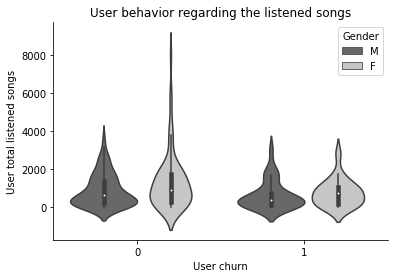

In [25]:
ax = sns.violinplot(data=user_behavior, x='churn', y='NextSong', hue='gender', palette="Greys_r")
plt.xlabel('User churn')
plt.ylabel('User total listened songs')
plt.legend(title='Gender', loc='best')
plt.title('User behavior regarding the listened songs')
sns.despine(ax=ax);

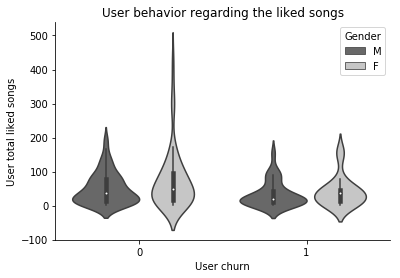

In [26]:
ax = sns.violinplot(data=user_behavior, x='churn', y='Thumbs Up', hue='gender', palette="Greys_r")
plt.xlabel('User churn')
plt.ylabel('User total liked songs')
plt.legend(title='Gender', loc='best')
plt.title('User behavior regarding the liked songs')
sns.despine(ax=ax);

#### 2.3.3 Churns per gender 

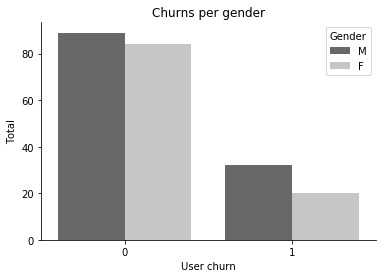

In [27]:
churn_gender = valid_user_logs.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").toPandas()

ax = sns.barplot(x='Churn', y='count', hue='gender', data=churn_gender, palette="Greys_r")
plt.xlabel('User churn')
plt.ylabel('Total')
plt.legend(title='Gender', loc='best')
plt.title('Churns per gender')
sns.despine(ax=ax);

#### 2.3.4 Songs per session

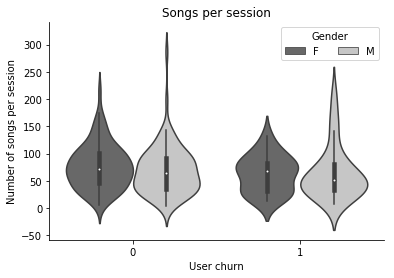

In [28]:
songs_per_session = valid_user_logs.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.violinplot('churn', y='avg_songs_played', hue='gender', data=songs_per_session, palette="Greys_r")
plt.xlabel('User churn')
plt.ylabel('Number of songs per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('Songs per session')
sns.despine(ax=ax);


#### 2.3.5 User churn point 

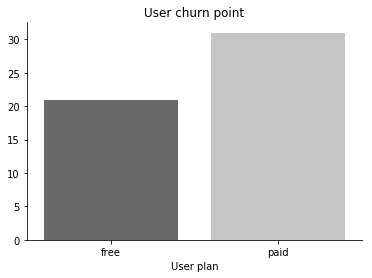

In [29]:
churn_point = valid_user_logs.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

ax = sns.barplot(data=churn_point, x='level', y='count', palette="Greys_r")
plt.xlabel('User plan')
plt.ylabel('')
plt.title('User churn point')
sns.despine(ax=ax);

#### 2.3.6 Registration time 

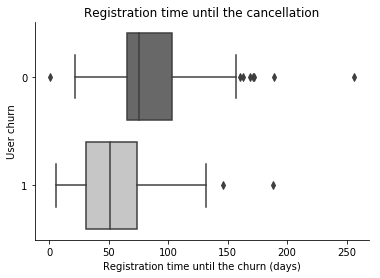

In [30]:
registration_period = valid_user_logs \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',(valid_user_logs.ts-valid_user_logs.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

ax = sns.boxplot(data=registration_period, y='churn', x='lifetime', orient='h', palette="Greys_r")
plt.xlabel('Registration time until the churn (days)')
plt.ylabel('User churn')
plt.title('Registration time until the cancellation')
sns.despine(ax=ax);

# Feature Engineering <a id='feature_engineer'></a>

We have already investigated the dataset, and we are ready to engineer the most promising features to train your model on.

#### Feature 1: Registration time 

The first feature we will engineer is the time period since the registration of the user. The Regirtation period could reflect the user loyality, engagement, and etc.

In [33]:
#Registration time
feature_1 = valid_user_logs \
    .select('userId','registration','ts') \
    .withColumn('registration_time',(valid_user_logs.ts-valid_user_logs.registration)) \
    .groupBy('userId') \
    .agg({'registration_time':'max'}) \
    .withColumnRenamed('max(registration_time)','registration_time') \
    .select('userId', (col('registration_time')/1000/3600/24).alias('registration_time'))
feature_1.describe().show()


+-------+------------------+-------------------+
|summary|            userId|  registration_time|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



#### Feature 2: Total number of listened songs


The second feature we will engineer is the total number of listened songs. The high number of listened songs indicated that the use spend more time with our service, and the user built a  deeper engagement which leads to the unlike possibility of cancellation of our services. 

In [34]:
# Total number of listened songs 
feature_2 = valid_user_logs \
    .select('userID','song') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_num_listened_songs')
feature_2.describe().show()

+-------+------------------+------------------------+
|summary|            userID|total_num_listened_songs|
+-------+------------------+------------------------+
|  count|               225|                     225|
|   mean|65391.013333333336|                 1236.24|
| stddev|105396.47791907164|       1329.531716432519|
|    min|                10|                       6|
|    max|                99|                    9632|
+-------+------------------+------------------------+



#### Feature 3: Total number of thumbs up


The third feature we will engineer is total number of thumbs up. This will reflect the quality of our service and the user engagement.

In [35]:
# Number of Thumbs-Up/Down
feature_3 = valid_user_logs \
    .select('userID','page') \
    .where(valid_user_logs.page == 'Thumbs Up') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_num_thumb_up') 
feature_3.describe().show()


+-------+------------------+------------------+
|summary|            userID|total_num_thumb_up|
+-------+------------------+------------------+
|  count|               220|               220|
|   mean| 66420.27727272727|             57.05|
| stddev|106196.51156121881| 65.67028650524044|
|    min|                10|                 1|
|    max|                99|               437|
+-------+------------------+------------------+



#### Feature 4: Total number of thumbs down



The third feature we will engineer is total number of thumbs down. This will reflect the quality of our service and the user engagement.

In [36]:
#Number of Thumbs-Down
feature_4 = valid_user_logs \
    .select('userID','page') \
    .where(valid_user_logs.page == 'Thumbs Down') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_num_thumb_down')
feature_4.describe().show()

+-------+------------------+--------------------+
|summary|            userID|total_num_thumb_down|
+-------+------------------+--------------------+
|  count|               203|                 203|
|   mean| 66066.16256157635|  12.541871921182265|
| stddev|106108.32569893777|  13.198108566983787|
|    min|                10|                   1|
|    max|                99|                  75|
+-------+------------------+--------------------+



#### Feature 5: Total number of songs added to a playlist

The fifth feature we will engineer is the total number of songs added to a playlist. The purpose of this feature is the same as the 3rd and 4th features.

In [37]:
# Total number of songs added to a playlist
feature_5 = valid_user_logs \
    .select('userID','page') \
    .where(valid_user_logs.page == 'Add to Playlist') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_songs_added_to_playlist')
feature_5.describe().show()

+-------+------------------+-----------------------------+
|summary|            userID|total_songs_added_to_playlist|
+-------+------------------+-----------------------------+
|  count|               215|                          215|
|   mean| 66103.63720930232|            30.35348837209302|
| stddev|106360.47999565038|             32.8520568555997|
|    min|                10|                            1|
|    max|                99|                          240|
+-------+------------------+-----------------------------+



#### Feature 6: Total number of added friend

The sixth feature we will engineer is the total number of added friends. The higher the number, the deeper the engagement of the user with our services. 

In [38]:
# Number of added friends 
feature_6 = valid_user_logs \
    .select('userID','page') \
    .where(valid_user_logs.page == 'Add Friend') \
    .groupBy('userID') \
    .count() \
    .withColumnRenamed('count', 'total_num_added_friend') 
feature_6.describe().show()

+-------+------------------+----------------------+
|summary|            userID|total_num_added_friend|
+-------+------------------+----------------------+
|  count|               206|                   206|
|   mean| 66076.91262135922|    20.762135922330096|
| stddev|106860.60517425007|    20.646779074405007|
|    min|                10|                     1|
|    max|                99|                   143|
+-------+------------------+----------------------+



#### Feature 7: Total listening lenght

The seventh feature we will engineer is the total listening length, serving the same purpose as the total number of listened songs, however within a time perspective.

In [39]:
# Total listening length 
feature_7 = valid_user_logs \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'total_listening_time')
feature_7.describe().show()

+-------+------------------+--------------------+
|summary|            userID|total_listening_time|
+-------+------------------+--------------------+
|  count|               225|                 225|
|   mean|65391.013333333336|  252558.32065155543|
| stddev|105396.47791907164|   275396.4038847635|
|    min|                10|           691.66884|
|    max|                99|  1991154.9155799907|
+-------+------------------+--------------------+



#### Feature 8: Total number of listened songs per session 

The eight feature we will engineer is the the average number of listened songs per session. The higher the number, the more time the user spend in our services. 

In [40]:
# Total number of listened songs per session 
feature_8 = valid_user_logs.where('page == "NextSong"') \
    .groupby(['userId', 'sessionId']) \
    .count() \
    .groupby(['userId']) \
    .agg({'count':'avg'}) \
    .withColumnRenamed('avg(count)', 'avg_num_listened_songs')
feature_8.describe().show()


+-------+------------------+----------------------+
|summary|            userId|avg_num_listened_songs|
+-------+------------------+----------------------+
|  count|               225|                   225|
|   mean|65391.013333333336|     70.78971233958933|
| stddev|105396.47791907164|      42.6153697543817|
|    min|                10|                   3.0|
|    max|                99|     286.6666666666667|
+-------+------------------+----------------------+



#### Feature 9: Total number of listened songs per session 

The ninth feature we will engineer is the gender, as we would like to inject demographic information about the user in our model as well. This feature will help us identify the differences between genders in terms of chance to churn.


In [41]:
# Gender
feature_9 = valid_user_logs \
    .select("userId", "gender") \
    .dropDuplicates() \
    .replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', col('gender').cast('int'))
feature_9.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



#### Feature 10: Number of listened artists

The tenth feature we will engineer is the number of listened artists. The higher the number, the more interesting and "unreplacable" our services are to the user. 

In [42]:
# Number of listened artists 
feature_10 = valid_user_logs \
    .filter(valid_user_logs.page=="NextSong") \
    .select("userId", "artist") \
    .dropDuplicates() \
    .groupby("userId") \
    .count() \
    .withColumnRenamed("count", "num_of_listened_artists")
feature_10.describe().show()

+-------+------------------+-----------------------+
|summary|            userId|num_of_listened_artists|
+-------+------------------+-----------------------+
|  count|               225|                    225|
|   mean|65391.013333333336|      696.3777777777777|
| stddev|105396.47791907164|      603.9518698630802|
|    min|                10|                      3|
|    max|                99|                   3544|
+-------+------------------+-----------------------+



Finally we need to label the churn

In [43]:
# Churn label
label = valid_user_logs \
    .select('userId', col('churn').alias('label')) \
    .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



Afterwards, we need to construct the whole feature dataframe by merging all the features and the label:

In [44]:
# Final feature dataframe 
features_df = feature_1.join(feature_2,'userID','outer') \
    .join(feature_3,'userID','outer') \
    .join(feature_4,'userID','outer') \
    .join(feature_5,'userID','outer') \
    .join(feature_6,'userID','outer') \
    .join(feature_7,'userID','outer') \
    .join(feature_8,'userID','outer') \
    .join(feature_9,'userID','outer') \
    .join(feature_10,'userID','outer') \
    .join(label,'userID','outer') \
    .drop('userID') \
    .fillna(0)

features_df.show(5)

+------------------+------------------------+------------------+--------------------+-----------------------------+----------------------+--------------------+----------------------+------+-----------------------+-----+
| registration_time|total_num_listened_songs|total_num_thumb_up|total_num_thumb_down|total_songs_added_to_playlist|total_num_added_friend|total_listening_time|avg_num_listened_songs|gender|num_of_listened_artists|label|
+------------------+------------------------+------------------+--------------------+-----------------------------+----------------------+--------------------+----------------------+------+-----------------------+-----+
|  55.6436574074074|                     381|                17|                   5|                            7|                     4|   66940.89735000003|    39.285714285714285|     1|                    252|    0|
| 70.07462962962963|                     474|                21|                   6|                            8|     

# Modelling <a id='modelling'></a>
Our evaluation metric will be the F-1 score. For evaluating th efficacy of our model we need a simple measure of the precision, e.g. whether we need to send a special offer to the right person, and the recall, e.g. whether we miss one user that we should have sent the offer, thus we choose the F1 score. 

We need to identify the user who are likely to cancel their subscription and provide them some special offers in order to persuade them to keep using our services, however we do not want to waste money and resources  and send way to many offers especially to users that are unlikely to churn. 


Our first step will be to vectorize our features.

In [45]:
# Vector assembler
columns = ["registration_time", "total_num_listened_songs", "total_num_thumb_up", \
          'total_num_thumb_down','total_songs_added_to_playlist','total_num_added_friend','total_listening_time','avg_num_listened_songs', \
        'gender', 'num_of_listened_artists']
vector_assembler = VectorAssembler(inputCols=columns, outputCol="NumFeatures")
features_df = vector_assembler.transform(features_df)

We also need to standardize the features so as to avoid a feature with higher scale dominant the whole model. We will achieve that by extract the mean of each feature and divide it with the standard deviation.

In [46]:
# Standard scaler
st_scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scaler_model = st_scaler.fit(features_df)
features_df = scaler_model.transform(features_df)

Next, we need split the data into train, validation, and test sets.

In [47]:
# Dataset split
train, rest = features_df.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

#### Baseline Model <a id='baseline'></a>



We evaluate two baseline models according to the churn type, specifically one with all users labelled as churn = 0 and the second one with all users labelled as churn = 0. Afterwards, we calculated the evaluation metrics of the model, e.g. accuracy and F1_score.

In [48]:
# Baseline model churn=1
baseline_users_1 = test.withColumn('prediction', lit(1.0))
evaluator_baseline_1 = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Evaluation metrics on the test set:')
print('Accuracy: {}'.format(evaluator_baseline_1.evaluate(baseline_users_1, {evaluator_baseline_1.metricName: "accuracy"})))
print('F1_Score:{}'.format(evaluator_baseline_1.evaluate(baseline_users_1, {evaluator_baseline_1.metricName: "f1"})))


Evaluation metrics on the test set:
Accuracy: 0.2647058823529412
F1_Score:0.11080711354309165


In [49]:
baseline_users_0 = test.withColumn('prediction', lit(0.0))
evaluator_baseline_0 = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Evaluation metrics on the test set:')
print('Accuracy: {}'.format(evaluator_baseline_0.evaluate(baseline_users_0, {evaluator_baseline_0.metricName: "accuracy"})))
print('F1_Score:{}'.format(evaluator_baseline_0.evaluate(baseline_users_0, {evaluator_baseline_0.metricName: "f1"})))

Evaluation metrics on the test set:
Accuracy: 0.7352941176470589
F1_Score:0.6231306081754736


Acording to the evaluation results on the test set, the baseline model of labelling all users with churn = 0 performs quite well reporting accuracy of 73,5% and f1 score of 62,3%.


Next we evaluate four different models. We need to minimize the chance of overfitting, so we will use cross validation and grid search to fine tune our model. We will evaluate all the four models on validation set, and we will choose the optimal one based on the F1_score on that, Finally, we will train train the best model on the training set again and then we will evaluate it on test set.



#### Logistic Regression <a id='logistic'></a>

In [46]:
# Initialize classifier and evaluator
log_regression = LogisticRegression(maxIter=10)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Set the paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_log_regression = CrossValidator(estimator=log_regression,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [47]:
start = time()
cv_model_lr = crossval_log_regression.fit(train)
end = time()
cv_model_lr.avgMetrics
print('The training process took {} seconds'.format(end - start))

The training process took 538.0229902267456 seconds


In [48]:
results_log_regression = cv_model_lr.transform(validation)

In [49]:
evaluator_log_regression = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Evaluation Metrics:')
print('Accuracy: {}'.format(evaluator_log_regression.evaluate(results_log_regression, {evaluator_log_regression.metricName: "accuracy"})))
print('F1_score:{}'.format(evaluator_log_regression.evaluate(results_log_regression, {evaluator_log_regression.metricName: "f1"})))

Logistic Regression Evaluation Metrics:
Accuracy: 0.8666666666666667
F1_score:0.8047619047619048


#### Gradient Boosted Trees <a id='gbt'></a>

In [50]:
# Initialize classifier and evaluator
gb_trees = GBTClassifier(maxIter=10,seed=42)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Set the paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_gb_trees = CrossValidator(estimator=gb_trees,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

start = time()
cv_model_gbt = crossval_gb_trees.fit(train)
end = time()
cv_model_gbt.avgMetrics
print('The training process took {} seconds'.format(end - start))

results_gb_trees = cv_model_gbt.transform(validation)

evaluator_gb_trees = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Evaluation Metrics:')
print('Accuracy: {}'.format(evaluator_gb_trees.evaluate(results_gb_trees, {evaluator_gb_trees.metricName: "accuracy"})))
print('F1_score:{}'.format(evaluator_gb_trees.evaluate(results_gb_trees, {evaluator_gb_trees.metricName: "f1"})))

The training process took 1081.77641248703 seconds
Gradient Boosted Trees Evaluation Metrics:
Accuracy: 0.8
F1_score:0.7703703703703705


#### Support Vector Machine <a id='svm'></a>

In [51]:
# Initialize classifier and evaluator
svm = LinearSVC(maxIter=10)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Set the paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

start = time()
cv_model_svm = crossval_svm.fit(train)
end = time()
cv_model_svm.avgMetrics
print('The training process took {} seconds'.format(end - start))

results_svm = cv_model_svm.transform(validation)

evaluator_svm = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Support Vector Machine Evaluation Metrics:')
print('Accuracy: {}'.format(evaluator_svm.evaluate(results_svm, {evaluator_svm.metricName: "accuracy"})))
print('F1_score:{}'.format(evaluator_svm.evaluate(results_svm, {evaluator_svm.metricName: "f1"})))

The training process took 725.581131696701 seconds
Support Vector Machine Evaluation Metrics:
Accuracy: 0.8666666666666667
F1_score:0.8047619047619048


#### Random Forest <a id='rf'></a>

In [52]:
# Initialize classifier and evaluator
r_forest = RandomForestClassifier(seed=42)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# Set the paramGrid
paramGrid = ParamGridBuilder() \
    .build()

crossval_r_forest = CrossValidator(estimator=r_forest,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

start = time()
cv_model_r_forest = crossval_r_forest.fit(train)
end = time()
cv_model_r_forest.avgMetrics
print('The training process took {} seconds'.format(end - start))

results_r_forest = cv_model_r_forest.transform(validation)

evaluator_r_forest = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Evaluation Metrics:')
print('Accuracy: {}'.format(evaluator_r_forest.evaluate(results_r_forest, {evaluator_r_forest.metricName: "accuracy"})))
print('F1_score:{}'.format(evaluator_r_forest.evaluate(results_r_forest, {evaluator_r_forest.metricName: "f1"})))

The training process took 620.2598252296448 seconds
Random Forest Evaluation Metrics:
Accuracy: 0.8666666666666667
F1_score:0.8047619047619048


### Models summary: 


|Model|Accuracy|F1_score|Seconds of training|
|------|------|------|------|
|Logistic Regression model|0.86|0.80|538.022|
|Gradient Boosted Trees model|0.8|0.77|1081.77|
|Support Vector Machine model|0.86|0.80|725.58|
|Random Forest model|0.86|0.80|620.25|


Since there is no difference between the 3 best models, Logistic Regression, Support Vector Machine and Random Forest, in terms of evaluation metrics performance and the ammount of training seconds (even if we care about time resources the difference are minimal), we will choose the 2 models that have the best evaluation results and the smallest ammount of training seconds. 

Therefore, we choose Logistic Regression and Random Forest models to conduct a grid search to fine tune them and finally select the best one. Moreover, we select the Random Forest to investigate the importance of each feature. 


#### Hyperparams tunning 
We use a ParamGridBuilder to construct a grid of parameters to search over.

### Best model <a id='best_model'></a>

### Logistic Regression 

In [53]:
lr = LogisticRegression(maxIter=10)

# build paramGrid
paramGrid = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

cv_model_lr = crossval_lr.fit(train)


In [54]:
list(zip(cv_model_lr.avgMetrics, paramGrid))

[(0.6794703442832867,
  {Param(parent='LogisticRegression_68b82afc0f0c', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LogisticRegression_68b82afc0f0c', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_68b82afc0f0c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0}),
 (0.6831235564368997,
  {Param(parent='LogisticRegression_68b82afc0f0c', name='regParam', doc='regularization parameter (>= 0).'): 0.1,
   Param(parent='LogisticRegression_68b82afc0f0c', name='fitIntercept', doc='whether to fit an intercept term.'): False,
   Param(parent='LogisticRegression_68b82afc0f0c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5}),
 (0.6831235564368997,
  {Param(parent='Logis

In [55]:
perf = pd.DataFrame(paramGrid, index=cv_model_lr.avgMetrics).reset_index()
perf.columns=['F1_score', 'regParam', 'fitIntercept', 'elasticNetParam']
perf

,F1_score,regParam,fitIntercept,elasticNetParam
0,0.679470,0.10,False,0.0
1,0.683124,0.10,False,0.5
2,0.683124,0.10,False,1.0
3,0.693044,0.10,True,0.0
4,0.683124,0.10,True,0.5
5,0.683124,0.10,True,1.0
6,0.696179,0.01,False,0.0
7,0.696179,0.01,False,0.5
8,0.679470,0.01,False,1.0
9,0.771949,0.01,True,0.0


In [56]:
lr_best = LogisticRegression(maxIter=10, regParam=0.01,fitIntercept= True,elasticNetParam=0.0)
lr_best_model = lr_best.fit(train)
final_results = lr_best_model.transform(test)
evaluator_lr = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Evaluation metrics on test set:')
print('Accuracy: {}'.format(evaluator_lr.evaluate(final_results, {evaluator_lr.metricName: "accuracy"})))
print('F1_core:{}'.format(evaluator_lr.evaluate(final_results, {evaluator_lr.metricName: "f1"})))




Evaluation metrics on test set:
Accuracy: 0.7647058823529411
F1_core:0.7184873949579832


### Random Forest

In [50]:
r_forest = RandomForestClassifier()

# build paramGrid

paramGrid = ParamGridBuilder() \
    .addGrid(r_forest.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(r_forest.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_r_forest = CrossValidator(estimator=r_forest,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

cv_model_r_forest = crossval_r_forest.fit(train)
list(zip(cv_model_r_forest.avgMetrics, paramGrid))


[(0.7797835365548991,
  {Param(parent='RandomForestClassifier_540437513958', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
   Param(parent='RandomForestClassifier_540437513958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5}),
 (0.7744194380535456,
  {Param(parent='RandomForestClassifier_540437513958', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
   Param(parent='RandomForestClassifier_540437513958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 15}),
 (0.7744194380535456,
  {Param(parent='RandomForestClassifier_540437513958', name='numTrees', doc='Number of trees to train (>= 1).'): 10,
   Param(parent='RandomForestClassifier_540437513958', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nod

In [51]:
perf = pd.DataFrame(paramGrid, index=cv_model_r_forest.avgMetrics).reset_index()
perf.columns=['F1_score','numTrees', 'maxDepth']
perf

,F1_score,numTrees,maxDepth
0,0.779784,10,5
1,0.774419,10,15
2,0.774419,10,25
3,0.798708,30,5
4,0.778139,30,15
5,0.778139,30,25
6,0.780731,50,5
7,0.772465,50,15
8,0.772465,50,25


In [57]:
r_forest_best = RandomForestClassifier(numTrees=30,maxDepth=5 )
r_forest_best_model = r_forest_best.fit(train)
final_results = r_forest_best_model.transform(test)
evaluator_r_forest = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Evaluation metrics on test set:')
print('Accuracy: {}'.format(evaluator_r_forest.evaluate(final_results, {evaluator_r_forest.metricName: "accuracy"})))
print('F1_core:{}'.format(evaluator_r_forest.evaluate(final_results, {evaluator_r_forest.metricName: "f1"})))



Evaluation metrics on test set:
Accuracy: 0.7794117647058824
F1_core:0.7600045496767834


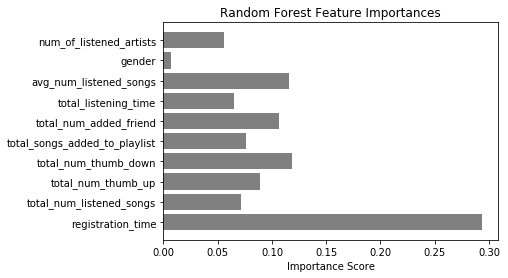

In [58]:
features_importance = r_forest_best_model.featureImportances.values

columns = ["registration_time", "total_num_listened_songs", "total_num_thumb_up", \
          'total_num_thumb_down','total_songs_added_to_playlist','total_num_added_friend','total_listening_time','avg_num_listened_songs', \
        'gender', 'num_of_listened_artists']
y_pos = np.arange(len(columns))
 
plt.barh(y_pos, features_importance, align='center', color="grey")
plt.yticks(y_pos, columns)
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importances');

Choosing the Random Forest model, give us the opportunity to use the feature importance function of the machine learning model. It is clear in the barplot above, that registration time into our service actually plays the most crucial role. The fact that the canceller had shorter registration time into our services indicates the bias of the above mentioned feature, and we might need to reconsider our model or reduce the bias with the help of some sort of transofrmation.
Furthermore, the total number of added friends, the total number of thumbs down, and the average number of listened songs also appear to be important features. For Instance, we might conclude that our song recommendations egine might not perform well and recommend the wrong songs to the user if the number of thumbs down is too high or we might conclude that a user loves our services and the songs provided in it, if the number of listened songs is high. 

Finally, the gender of the user plays almost no important role in our model. 

# Conclusion <a id='conclusion'></a>



### Summary

In this project, we built a machine learning model trcapable to predict wheter a user will churn. We performed multiple preprocess steps, namely we removed rows with missing userId, we converted time columns containing timestamp data into a more human readable format, we converted the gender column itno a binary numeric column. We performed an extensive Exploratory Data Analysis, we visualized coll plots that describe valuable statistics of the users, and we engineered 10 features for our machine learning model.
Next, we chose 4 different machine leatning models for our analysis: Logistic Regression, Gradient Boosted Trees, Support Vector Machine, and Random Forest to compare and we chose the Logistic Regression and Random Forest, as the most promising models based on the evaluation metrics and the seconds needed for training. Furthermore, we utilized a cross validation and Gridsearch to fine tune both models and based on the evaluation results on the test set we chose the Random Forest as our final model. We achieved about 78% accuracy, and 76% F1 score, which is about 16% improvement compare to our baseline model e.g. sending everyone an offer.

### Reflection


In this project we aim to reveal the Spark environment as an analysis tool for large volume of data that a personal laptop/machine would be probably uncapable of anylizing. Predicting the potential cancellers of services before the actual churn, gives companies the oportunity to send targeted messages and offers and minimize the cost of saving existing customers. Still, engineering appropriate and informative features from the available data is the number one interesting challenge of the project. However, engineer informative features is higly important in builting a good predictive model, and unfortunatelly is a costly and time consuming effort. Exploratory and explanatory data analysis plays an important role in feature engineering as well.



### Improvement



Adding extra domain knowledge and expertise could significantly improve the feature engineering of this project. As the user database grow, more data will be available to analyze with tools such as Spark and the results would be improved importantly. Currently, we utilized for our analusis 450 records of unique users of our services, and only the 60% of them were used for training our machine learning model. However, the model could go though a great improvement if the training sample increase, and the expected model performance will increase as well.